Copyright ©2021-2022. Stephen Rigden.
This program is free software: you can redistribute it and/or modify it under the terms of the GNU General Public License as published by the Free Software Foundation, either version 3 of the License, or (at your option) any later version.
This program is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the GNU General Public License for more details.
You should have received a copy of the GNU General Public License along with this program.  If not, see <http://www.gnu.org/licenses/>.

# Plot Heart Rate

In [114]:
import pandas
from pathlib import Path
from matplotlib import pyplot
import seaborn

from utilities import TimeCategories


seaborn.set_style('darkgrid')  # one of {darkgrid, whitegrid, dark, white, ticks}

In [115]:
project_path = Path.cwd().parent
heart_df_pickle = project_path / 'data' / 'processed' / 'heart_preprocessed.pickle'
blood_pressure_pdf = project_path / 'reports' / 'blood_pressure.pdf'
blood_pressure_jpg = project_path / 'reports' / 'blood_pressure.jpg'

In [116]:
ds = pandas.read_pickle(heart_df_pickle)
ds.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 176911 entries, 5 to 176915
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   value   176911 non-null  float64       
 1   type    176911 non-null  object        
 2   date    176911 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 5.4+ MB


In [117]:
bp_diastolic = ds['type'] == 'HKQuantityTypeIdentifierBloodPressureDiastolic'
bp_systolic = ds['type'] == 'HKQuantityTypeIdentifierBloodPressureSystolic'
ds_sys = ds.loc[bp_systolic, ['date', 'value']]
ds_sys = ds_sys.rename(columns={'value': 'systolic'})
ds_dia = ds.loc[bp_diastolic, ['date', 'value']]
ds_dia = ds_dia.rename(columns={'value': 'diastolic'})
bpds = ds_sys.merge(ds_dia, left_on=['date'], right_on=['date'])
bpds['pulse pressure'] = bpds['systolic'] - bpds['diastolic']
bpds.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 384 entries, 0 to 383
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date            384 non-null    datetime64[ns]
 1   systolic        384 non-null    float64       
 2   diastolic       384 non-null    float64       
 3   pulse pressure  384 non-null    float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 15.0 KB


In [118]:
bpds.head()

,date,systolic,diastolic,pulse pressure
0,2021-08-06 20:53:00,153.0,79.0,74.0
1,2021-08-06 20:58:00,136.0,85.0,51.0
2,2021-08-06 23:13:00,135.0,77.0,58.0
3,2021-08-07 01:14:00,121.0,73.0,48.0
4,2021-08-07 22:21:00,132.0,71.0,61.0


In [119]:
start = bpds.date.min()
print(f'{start=}')
end = bpds.date.max()
period_of_interest = end - start
bucket_size = int(str(period_of_interest.days)) // 10
categories = TimeCategories(start, end, bucket_size)
categories

start=Timestamp('2021-08-06 20:53:00')


TimeCategories(start_date=Timestamp('2021-08-13 22:52:00'), end_date=Timestamp('2021-11-30 22:52:00'), bucket_size=11)

In [120]:
bpds['bucket'] = bpds['date'].apply(categories.get_bucket)
bpds.tail()

,date,systolic,diastolic,pulse pressure,bucket
379,2021-11-29 23:18:00,141.0,76.0,65.0,2021-11-30
380,2021-11-29 23:56:00,143.0,72.0,71.0,2021-11-30
381,2021-11-30 03:41:00,134.0,72.0,62.0,2021-11-30
382,2021-11-30 21:29:00,148.0,76.0,72.0,2021-11-30
383,2021-11-30 22:52:00,140.0,79.0,61.0,2021-11-30


[Text(0.5, 0, '11 Day intervals'), Text(0, 0.5, 'observation count')]

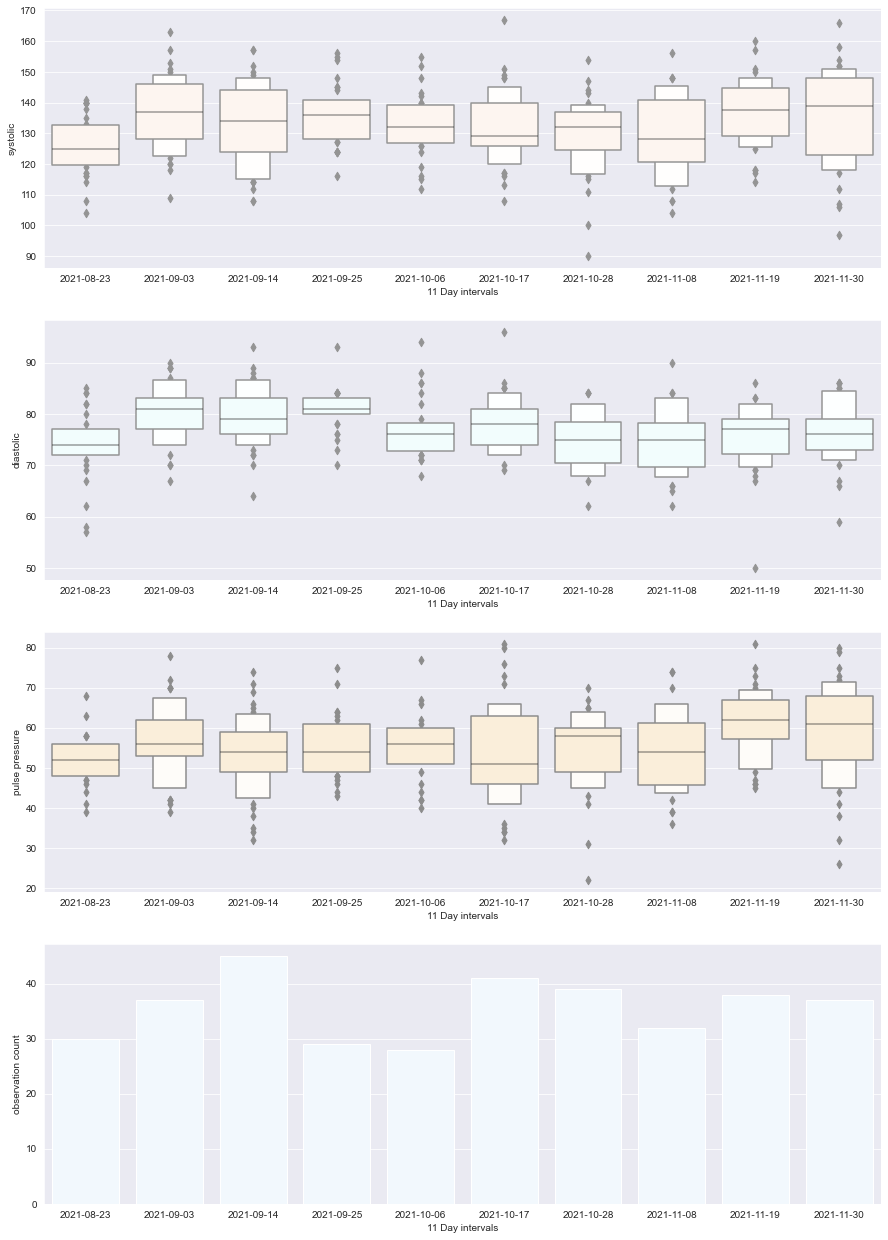

In [123]:
fig, axes = pyplot.subplots(nrows=4, ncols=1, figsize=(15, 22))

# Plot systolic
seaborn.boxenplot(data=bpds,
                  x='bucket', y='systolic',
                  ax=axes[0],
                  palette=['seashell']
                  )

# Plot diastolic
seaborn.boxenplot(data=bpds,
                  x='bucket', y='diastolic',
                  ax=axes[1],
                  palette=['azure']
                  )

# Plot pulse pressure
seaborn.boxenplot(data=bpds,
                  x='bucket', y='pulse pressure',
                  ax=axes[2],
                  palette=['papayawhip']
                  )

# Plot observation counts
seaborn.countplot(data=bpds,
                  x='bucket',
                  ax=axes[3],
                  palette=['aliceblue']
                  )

axes[0].set(xlabel=f'{bucket_size} Day intervals')
axes[1].set(xlabel=f'{bucket_size} Day intervals')
axes[2].set(xlabel=f'{bucket_size} Day intervals')
axes[3].set(xlabel=f'{bucket_size} Day intervals', ylabel='observation count')

In [122]:
# Save the plots
fig.savefig(blood_pressure_jpg)
fig.savefig(blood_pressure_pdf)